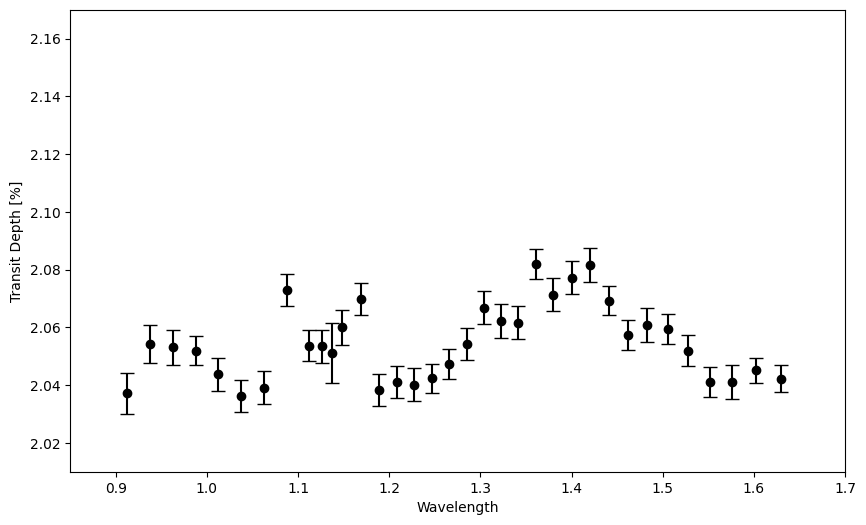

In [57]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

res = h5py.File('piaulet_iraclis_ace.h5','r') # replace this with one of your retrievals

factor=1e2

plt.figure(figsize=(10,6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()]*factor, 
             yerr = res['Observed']['errorbars'][()]*factor,
            fmt='o', c='k', capsize=5)
plt.xlim(0.85,1.7)
plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

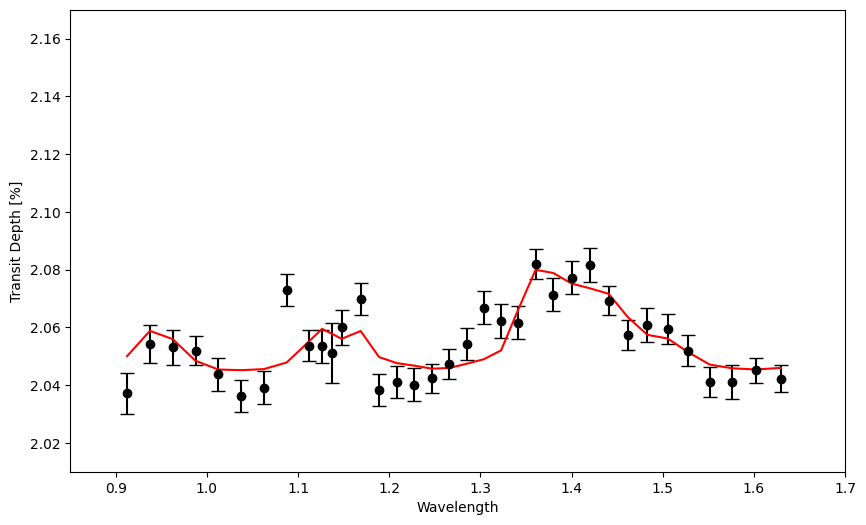

In [58]:
res_spec = res['Output']['Solutions']['solution0']['Spectra']

"""You can plot the best-fit spectrum at the binned resolution but it looks ugly"""

plt.figure(figsize=(10,6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()]*factor, 
             yerr = res['Observed']['errorbars'][()]*factor,
            fmt='o', c='k', capsize=5)
plt.plot(res_spec['binned_wlgrid'][()],res_spec['binned_spectrum'][()]*factor,c='r')
plt.xlim(0.85,1.7)
plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()


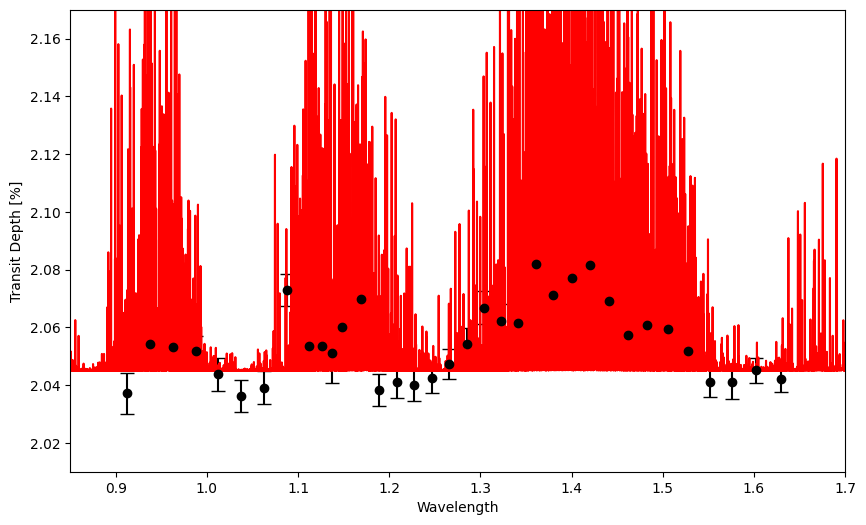

In [60]:
"""Same for the native...."""

plt.figure(figsize=(10,6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()]*factor, 
             yerr = res['Observed']['errorbars'][()]*factor,
            fmt='o', c='k', capsize=5)
plt.plot(res_spec['native_wlgrid'][()],res_spec['native_spectrum'][()]*factor,c='r')
plt.xlim(0.85,1.7)
plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

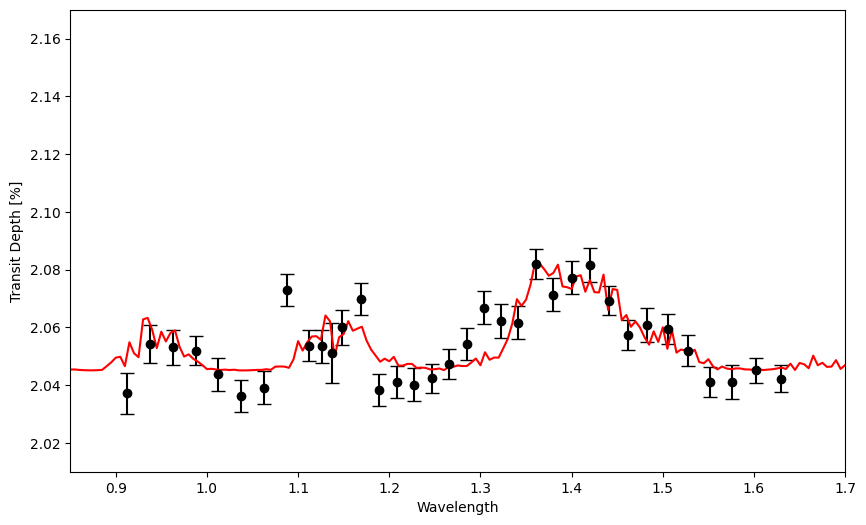

In [61]:
from taurex.binning.fluxbinner import FluxBinner
from taurex.util.util import wnwidth_to_wlwidth
import pandas as pd

def bin_spectrum(low_res, high_res):
        
    transmission_spectra = high_res.sort_values(by = 'wavelength')
    low_res = low_res.sort_values(by = 'wavelength')
    low_res = low_res.reset_index(drop = True)
    
    binner  = FluxBinner(low_res['wavelength'].values)

    _, binned_transit_depth, _,  _ = binner.bindown(transmission_spectra['wavelength'].values, 
                                                    transmission_spectra['depth'].values)
    
    return np.array(binned_transit_depth)

"""So let's bin it tro something in-between"""

hr = pd.DataFrame(res_spec['native_wlgrid'][()],columns=['wavelength'])
hr['depth'] = res_spec['native_spectrum'][()]

bd = 0.005
lr = pd.DataFrame(np.arange(0.6,5,bd),columns=['wavelength'])
lr['depth'] = bin_spectrum(lr.copy(), hr)

plt.figure(figsize=(10,6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()]*factor, 
             yerr = res['Observed']['errorbars'][()]*factor,
            fmt='o', c='k', capsize=5)
plt.plot(lr['wavelength'],lr['depth']*factor,c='r')
plt.xlim(0.85,1.7)
plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

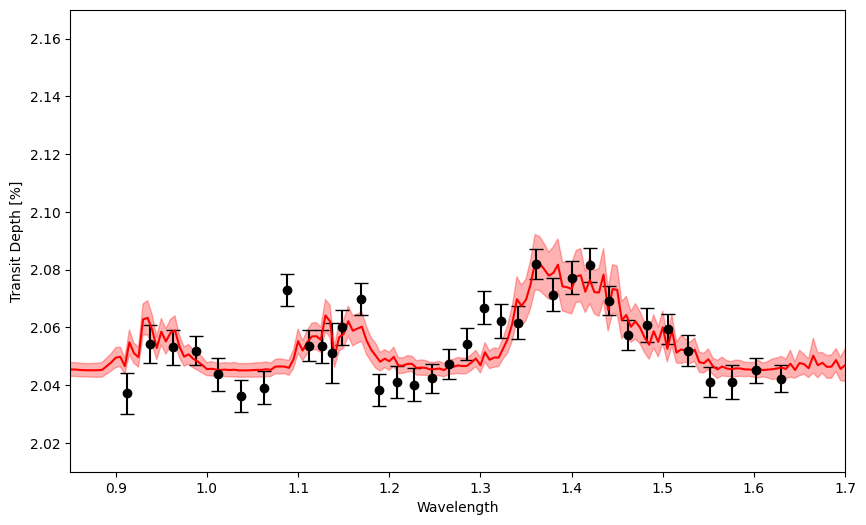

In [62]:
"""Might also want to plot 1 sigma uncertainities on the best-fit model..."""

hr_plus_std = hr.copy()
hr_plus_std['depth'] = res_spec['native_spectrum'][()] + res_spec['native_std'][()]

hr_minus_std = hr.copy()
hr_minus_std['depth'] = res_spec['native_spectrum'][()] - res_spec['native_std'][()]

lr['depth_m_std'] = bin_spectrum(lr.copy(), hr_minus_std)
lr['depth_p_std'] = bin_spectrum(lr.copy(), hr_plus_std)

plt.figure(figsize=(10,6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()]*factor, 
             yerr = res['Observed']['errorbars'][()]*factor,
            fmt='o', c='k', capsize=5)
plt.plot(lr['wavelength'],lr['depth']*factor,c='r')
plt.fill_between(lr['wavelength'],lr['depth_m_std']*factor,lr['depth_p_std']*factor,color='r',alpha=0.3)
plt.xlim(0.85,1.7)
plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

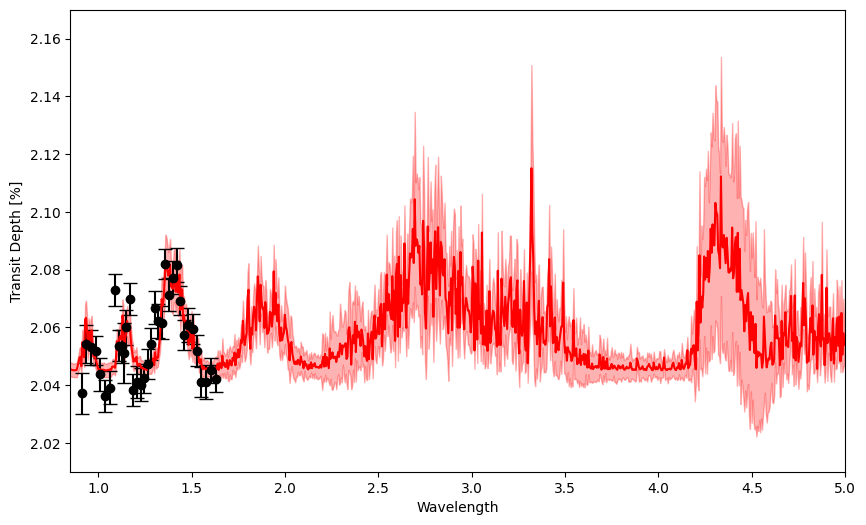

In [64]:
"""Can also be interesting to project to longer wavelengths. In this case, the big uncertainty at ~4.5
micron is because the retrieval could not well constrain carbon-bearing species (e.g., CO2)"""

plt.figure(figsize=(10,6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()]*factor, 
             yerr = res['Observed']['errorbars'][()]*factor,
            fmt='o', c='k', capsize=5)
plt.plot(lr['wavelength'],lr['depth']*factor,c='r')
plt.fill_between(lr['wavelength'],lr['depth_m_std']*factor,lr['depth_p_std']*factor,color='r',alpha=0.3)
plt.xlim(0.85,5.)
plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

In [12]:
#Get the Bayesian evidence, ln(E)
evidence = res['Output']['Solutions']['solution0']['Statistics']['local log-evidence'][()]
evidence

255.38783706393656

In [14]:
import scipy as sp
from scipy.special import *
from numpy import interp

"""A function to compare the Bayesian evidence and convert the difference to sigma"""

def sigma(lnz1,lnz2):
    
    lnB = lnz1 - lnz2
    logp = np.arange(-100.00,0.00,.1) #reverse order
    logp = logp[::-1] # original order
    P = 10.0**logp
    Barr = -1./(np.exp(1)*P*np.log(P))

    sigma = np.arange(0.1,100.10,.01)
    p_p = sp.special.erfc(sigma/np.sqrt(2.0))
    B = np.exp(lnB)
    pvalue = 10.0**interp(np.log10(B),np.log10(Barr),np.log10(P))
    sig = interp(pvalue,p_p[::-1],sigma[::-1])
                
    return sig

evidence_2 = 252

sigma(evidence,evidence_2)

3.0902806946296337

[[b'planet_radius']
 [b'T_surface']
 [b'T_top']
 [b'log_P_top']
 [b'log_P_point1']
 [b'log_P_point2']
 [b'T_point1']
 [b'T_point2']
 [b'log_metallicity']
 [b'C_O_ratio']
 [b'log_clouds_pressure']
 [b'Offset_1']]


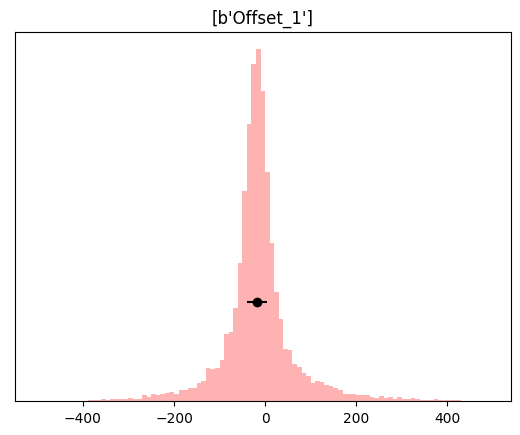

In [118]:
"""output file also contrains all the traces so you can replot the posteriors"""

fit_para = res['Optimizer']['fit_parameter_names'][()]
final_para = res['Output']['Solutions']['solution0']['fit_params']

print(fit_para) # list of fitted parameters

traces = res['Output']['Solutions']['solution0']['tracedata'][()]

#lets plot the offset between G102 and G141
idx=11
plt.figure()
plt.hist(traces[:,idx]*1e6,bins=np.arange(-500,500,10),color='r',alpha=0.3)
plt.errorbar(final_para['Offset_1']['value'][()]*1e6, 500, 
             xerr=[[final_para['Offset_1']['sigma_m'][()]*1e6],[final_para['Offset_1']['sigma_p'][()]*1e6]],
            fmt='o',c='k')
plt.title(fit_para[idx])
plt.yticks([])
plt.show()